In [3]:
#%pip install scikeras
#%pip install spectral
#%pip install scikit-optimize
%pip install --upgrade tensorflow
%pip install --upgrade keras
#%pip install tqdm
%pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\wb8by\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\wb8by\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\wb8by\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
import os
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Input, Lambda
import scikeras
import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from scipy.stats import reciprocal
from sklearn.metrics import accuracy_score
# hyperparameter optimization methods
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_evaluations
from skopt.callbacks import CheckpointSaver
#import optuna
#from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
#import hyperopt
import pickle
import pandas as pd
import skopt
from sklearn.model_selection import train_test_split, cross_val_score
import tqdm # nice progress bar

print(f'Numpy Version: {np. __version__}')
print(f'TensorFlow Version: {tf. __version__}')
print(f'Keras Version: {keras. __version__}')

Numpy Version: 1.24.3
TensorFlow Version: 2.16.2
Keras Version: 3.4.1


# Load the UPWINS spectral library and metadata csv

In [288]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
wl = np.load('data/wl.npy')
genus = np.load('data/genus.npy')
species = np.load('data/species.npy')
principle_part = np.load('data/principle_part.npy')
health = np.load('data/health.npy')
growth_stage = np.load('data/growth_stage.npy')
DateTimeId = np.load('data/DateTimeId.npy')
month = np.load('data/month.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA

nSpec = spectra.shape[0]
nBands = spectra.shape[1]
print(f'Min wavelength: {np.min(wl)}')
print(f'Max wavelength: {np.max(wl)}')
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Min wavelength: 350.0
Max wavelength: 2500.0
Number of Spectra: 902
Number of Bands: 2151


# Prepare the data for training and testing

In [6]:
# Assemble X and Y for training
X = spectra
Yn = name
Yg = genus
Ys = species
Ypp = principle_part
Yh = health
Ygs = growth_stage
Yd = DateTimeId
Ym = month
Yngs = name_genus_species
Ynfc = name_full_category
Ypt = plant_type
print(X.shape,Yn.shape)
print(f'Number of genus: {len(np.unique(Yg))}: {np.unique(Yg)}\n')
print(f'Number of species: {len(np.unique(Ys))}: {np.unique(Ys)}\n')
print(f'Number of principle_parts: {len(np.unique(Ypp))}: {np.unique(Ypp)}\n')
print(f'Number of health categories: {len(np.unique(Yh))}: {np.unique(Yh)}\n')
print(f'Number of growth stage categories: {len(np.unique(Ygs))}: {np.unique(Ygs)}\n')
print(f'Number of Date-Time_Id values: {len(np.unique(Yd))}\n')
print(f'Number of months: {len(np.unique(Ym))}: {np.unique(Ym)}\n')
print(f'Number of names: {len(np.unique(Yn))}: {np.unique(Yn)}\n')
print(f'Number of name_genus_species categories: {len(np.unique(Yngs))}: {np.unique(Yngs)}\n')
print(f'Number of name_full_categories: {len(np.unique(Ynfc))}\n')
print(f'Number of plant types: {len(np.unique(Ypt))}: {np.unique(Ypt)}\n')

(902, 2151) (902,)
Number of genus: 10: ['Ammophila' 'Baccharis' 'Chamaecrista' 'Chasmanthium' 'Ilex' 'Iva' 'NA'
 'Panicum' 'Rosa' 'Solidago']

Number of species: 11: ['NA' 'amarum' 'breviligulata' 'fasciculata' 'frutescens' 'halimifolia'
 'latifolium' 'rugosa' 'sempervirens' 'virgatum' 'vomitoria']

Number of principle_parts: 10: ['B' 'CS' 'FL' 'L' 'MX' 'NA' 'RS' 'S' 'SA' 'St']

Number of health categories: 7: ['D' 'H' 'LLRZ' 'MX' 'NA' 'R' 'S']

Number of growth stage categories: 8: [' M' '1G' 'D' 'E' 'FL' 'M' 'NA' 'RE']

Number of Date-Time_Id values: 902

Number of months: 8: ['01' '02' '03' '04' '07' '10' '11' '12']

Number of names: 18: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Panicum_amarum' 'Panicum_virgatum' 'Rosa_rugosa'
 'Solidago_sempervirens' 'clay' 'golf-course-sand' 'grass' 'iris'
 'milkweed' 'pasturegrass' 'soybean' 'timothy']

Number of name_genus_species categories: 11: 

In [7]:
Y_type = Yn
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]

In [8]:
# Create a test-train split
X_train80, X_test, Y_train80, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train80, Y_train80, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

(540, 2151) 0.5986696230598669
(181, 2151) 0.2006651884700665
(181, 2151) 0.2006651884700665


In [9]:
# Classification results using lazy classifier
rerun_LazyClassifier = False
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train, X_test, Y_train, Y_test)
    models.to_csv(f'output/LazyClassifier_results_full_category.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_full_category.csv')
models

Model  Accuracy  Balanced Accuracy  ROC AUC  \
0      LinearDiscriminantAnalysis      0.93               0.94      NaN   
1            ExtraTreesClassifier      0.88               0.87      NaN   
2          RandomForestClassifier      0.88               0.86      NaN   
3                  LGBMClassifier      0.87               0.86      NaN   
4               RidgeClassifierCV      0.85               0.85      NaN   
5               BaggingClassifier      0.86               0.85      NaN   
6                   XGBClassifier      0.85               0.85      NaN   
7             ExtraTreeClassifier      0.80               0.80      NaN   
8                 RidgeClassifier      0.78               0.77      NaN   
9          CalibratedClassifierCV      0.78               0.76      NaN   
10             LogisticRegression      0.76               0.73      NaN   
11                      LinearSVC      0.73               0.73      NaN   
12         DecisionTreeClassifier      0.76               0.73      NaN   
13                 LabelSpreading      0.66               0.67      NaN   
14               LabelPropagation      0.66               0.67      NaN   
15           KNeighborsClassifier      0.67               0.64      NaN   
16    PassiveAggressiveClassifier      0.57               0.54      NaN   
17                            SVC      0.59               0.54      NaN   
18                  SGDClassifier      0.60               0.53      NaN   
19                     Perceptron      0.45               0.41      NaN   
20                     GaussianNB      0.39               0.36      NaN   
21                    BernoulliNB      0.37               0.35      NaN   
22                NearestCentroid      0.34               0.31      NaN   
23  QuadraticDiscriminantAnalysis      0.33               0.30      NaN   
24             AdaBoostClassifier      0.28               0.23      NaN   
25                DummyClassifier      0.12               0.09      NaN   

    F1 Score  Time Taken  
0       0.93        0.46  
1       0.88        0.49  
2       0.88        1.91  
3       0.87       40.21  
4       0.85        0.21  
5       0.86        7.53  
6       0.85       30.36  
7       0.80        0.07  
8       0.78        0.11  
9       0.78       61.07  
10      0.76        0.62  
11      0.74       15.02  
12      0.76        1.21  
13      0.68        0.12  
14      0.68        0.13  
15      0.66        0.51  
16      0.59        1.11  
17      0.57        0.46  
18      0.60        0.64  
19      0.42        0.50  
20      0.37        0.12  
21      0.34        0.09  
22      0.35        0.09  
23      0.30        0.27  
24      0.18        8.71  
25      0.02        0.08

In [ ]:
stop[here]

# Build an initial NN model

In [10]:
# Model with one hidden layer (128 neurons) with dropout (probability = 0.2), with one final layer.
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.) <- if we want to control initial weights

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(128, activation='relu'),
#    #tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(nClasses, activation='softmax')
#])

# Comile the layer -> set the optimizer, loss function, and metrics to track.
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

# Fit (train) the model
#history = model.fit(X_train80, Y_train80, epochs=2000, batch_size=32);

Epoch 1/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1404 - loss: 2.6891
Epoch 2/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2382 - loss: 2.3990
Epoch 3/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3167 - loss: 2.2849 
Epoch 4/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3047 - loss: 2.1472 
Epoch 5/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3426 - loss: 2.1993 
Epoch 6/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2957 - loss: 2.2222 
Epoch 7/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3347 - loss: 2.0603 
Epoch 8/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4171 - loss: 2.0136 
Epoch 9/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4230 - loss: 1.9564 
Epoch 10/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3807 - loss: 1.9689 
Epoch 11/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4098 - loss: 1.9440 
Epoch 12/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

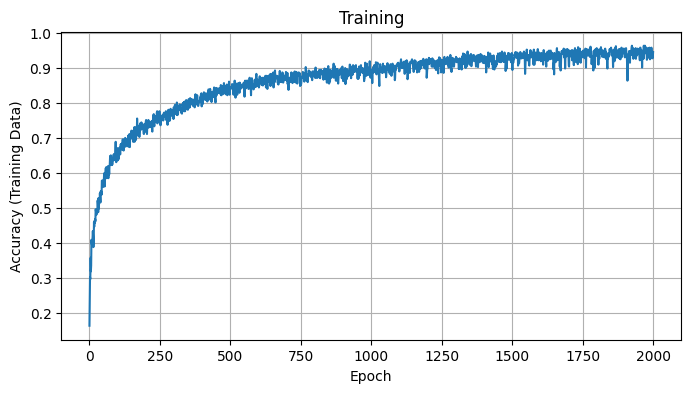

In [59]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Training Data)')
plt.title('Training');
plt.savefig('trainingHistoryAccuracy.png')

In [250]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 0s - 14ms/step - accuracy: 0.8729 - loss: 1.3223

Test accuracy: 0.8729282021522522


In [12]:
predicted = model.predict(X_test)
actual = tf.stack(Y_test, axis=0)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


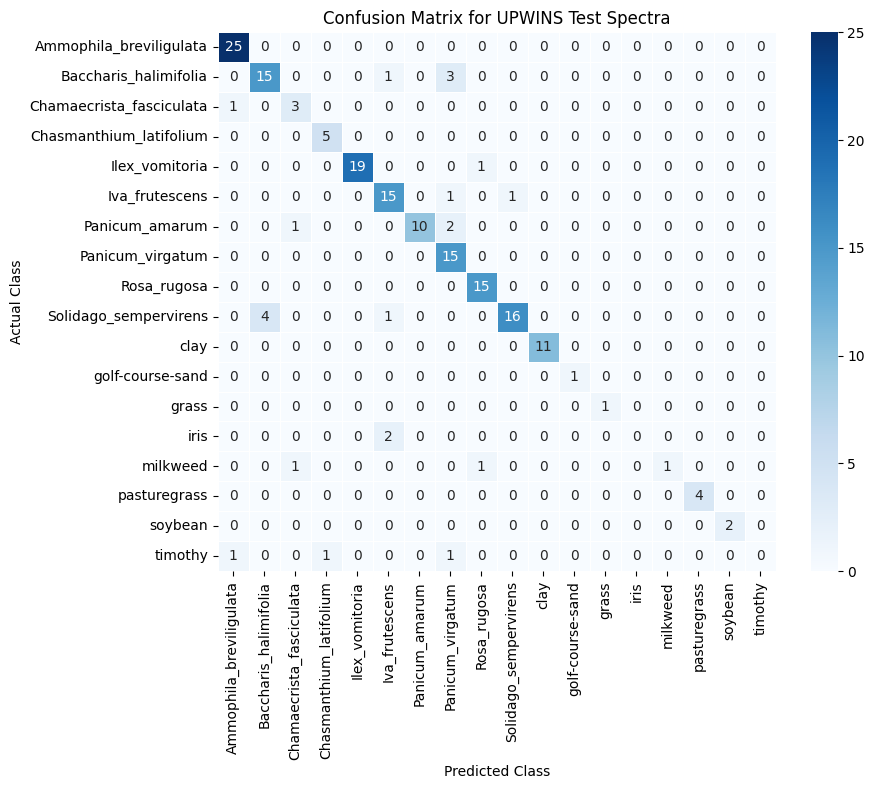

In [44]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(actual, predicted, Y_labels, 'test')
plt.savefig('confusionMatrix.png')

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,336 (3.18 MB)

 Trainable params: 277,778 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,558 (2.12 MB)

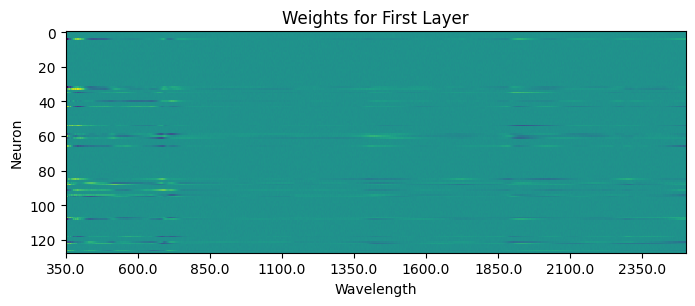

In [252]:
# Visualize the first layer as an image
hidden = model.layers[0]
hidden.name
weights_1, biases_1 = hidden.get_weights()

plt.figure(figsize=(8,3))
plt.imshow(weights_1.T, aspect='6', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for First Layer');
plt.tight_layout()
plt.savefig('output/Layer1WeightsImAll.png')

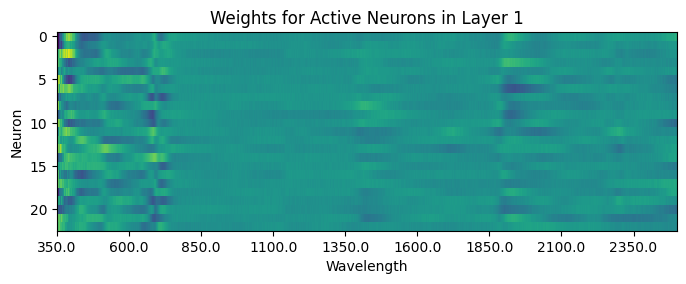

In [254]:
# determine the indices for neurons with structure
indices = np.where(np.std(weights_1, axis=0) > 0.1)[0]
active_weights_1 = weights_1[:,indices].T
active_biases_1 = biases_1[indices]

plt.figure(figsize=(8,3))
plt.imshow(active_weights_1, aspect='30', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for Active Neurons in Layer 1');
plt.tight_layout()
plt.savefig('output/Layer1WeightsIm.png')

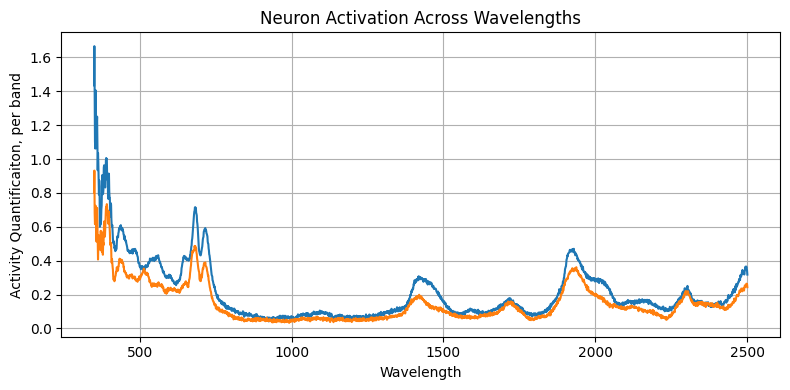

In [264]:
activity = np.mean(np.abs(active_weights_1),axis=0)
activity_var = np.std(np.abs(active_weights_1),axis=0)

plt.figure(figsize=(8,4))
plt.plot(wl,activity, label='Mean Absulte Value of Weight')
plt.plot(wl,activity_var, label='Standard deviation in Weight')
plt.xlabel('Wavelength')
plt.ylabel('Activity Quantificaiton, per band')
plt.title('Neuron Activation Across Wavelengths')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/NeuronActivityPerWL.png')

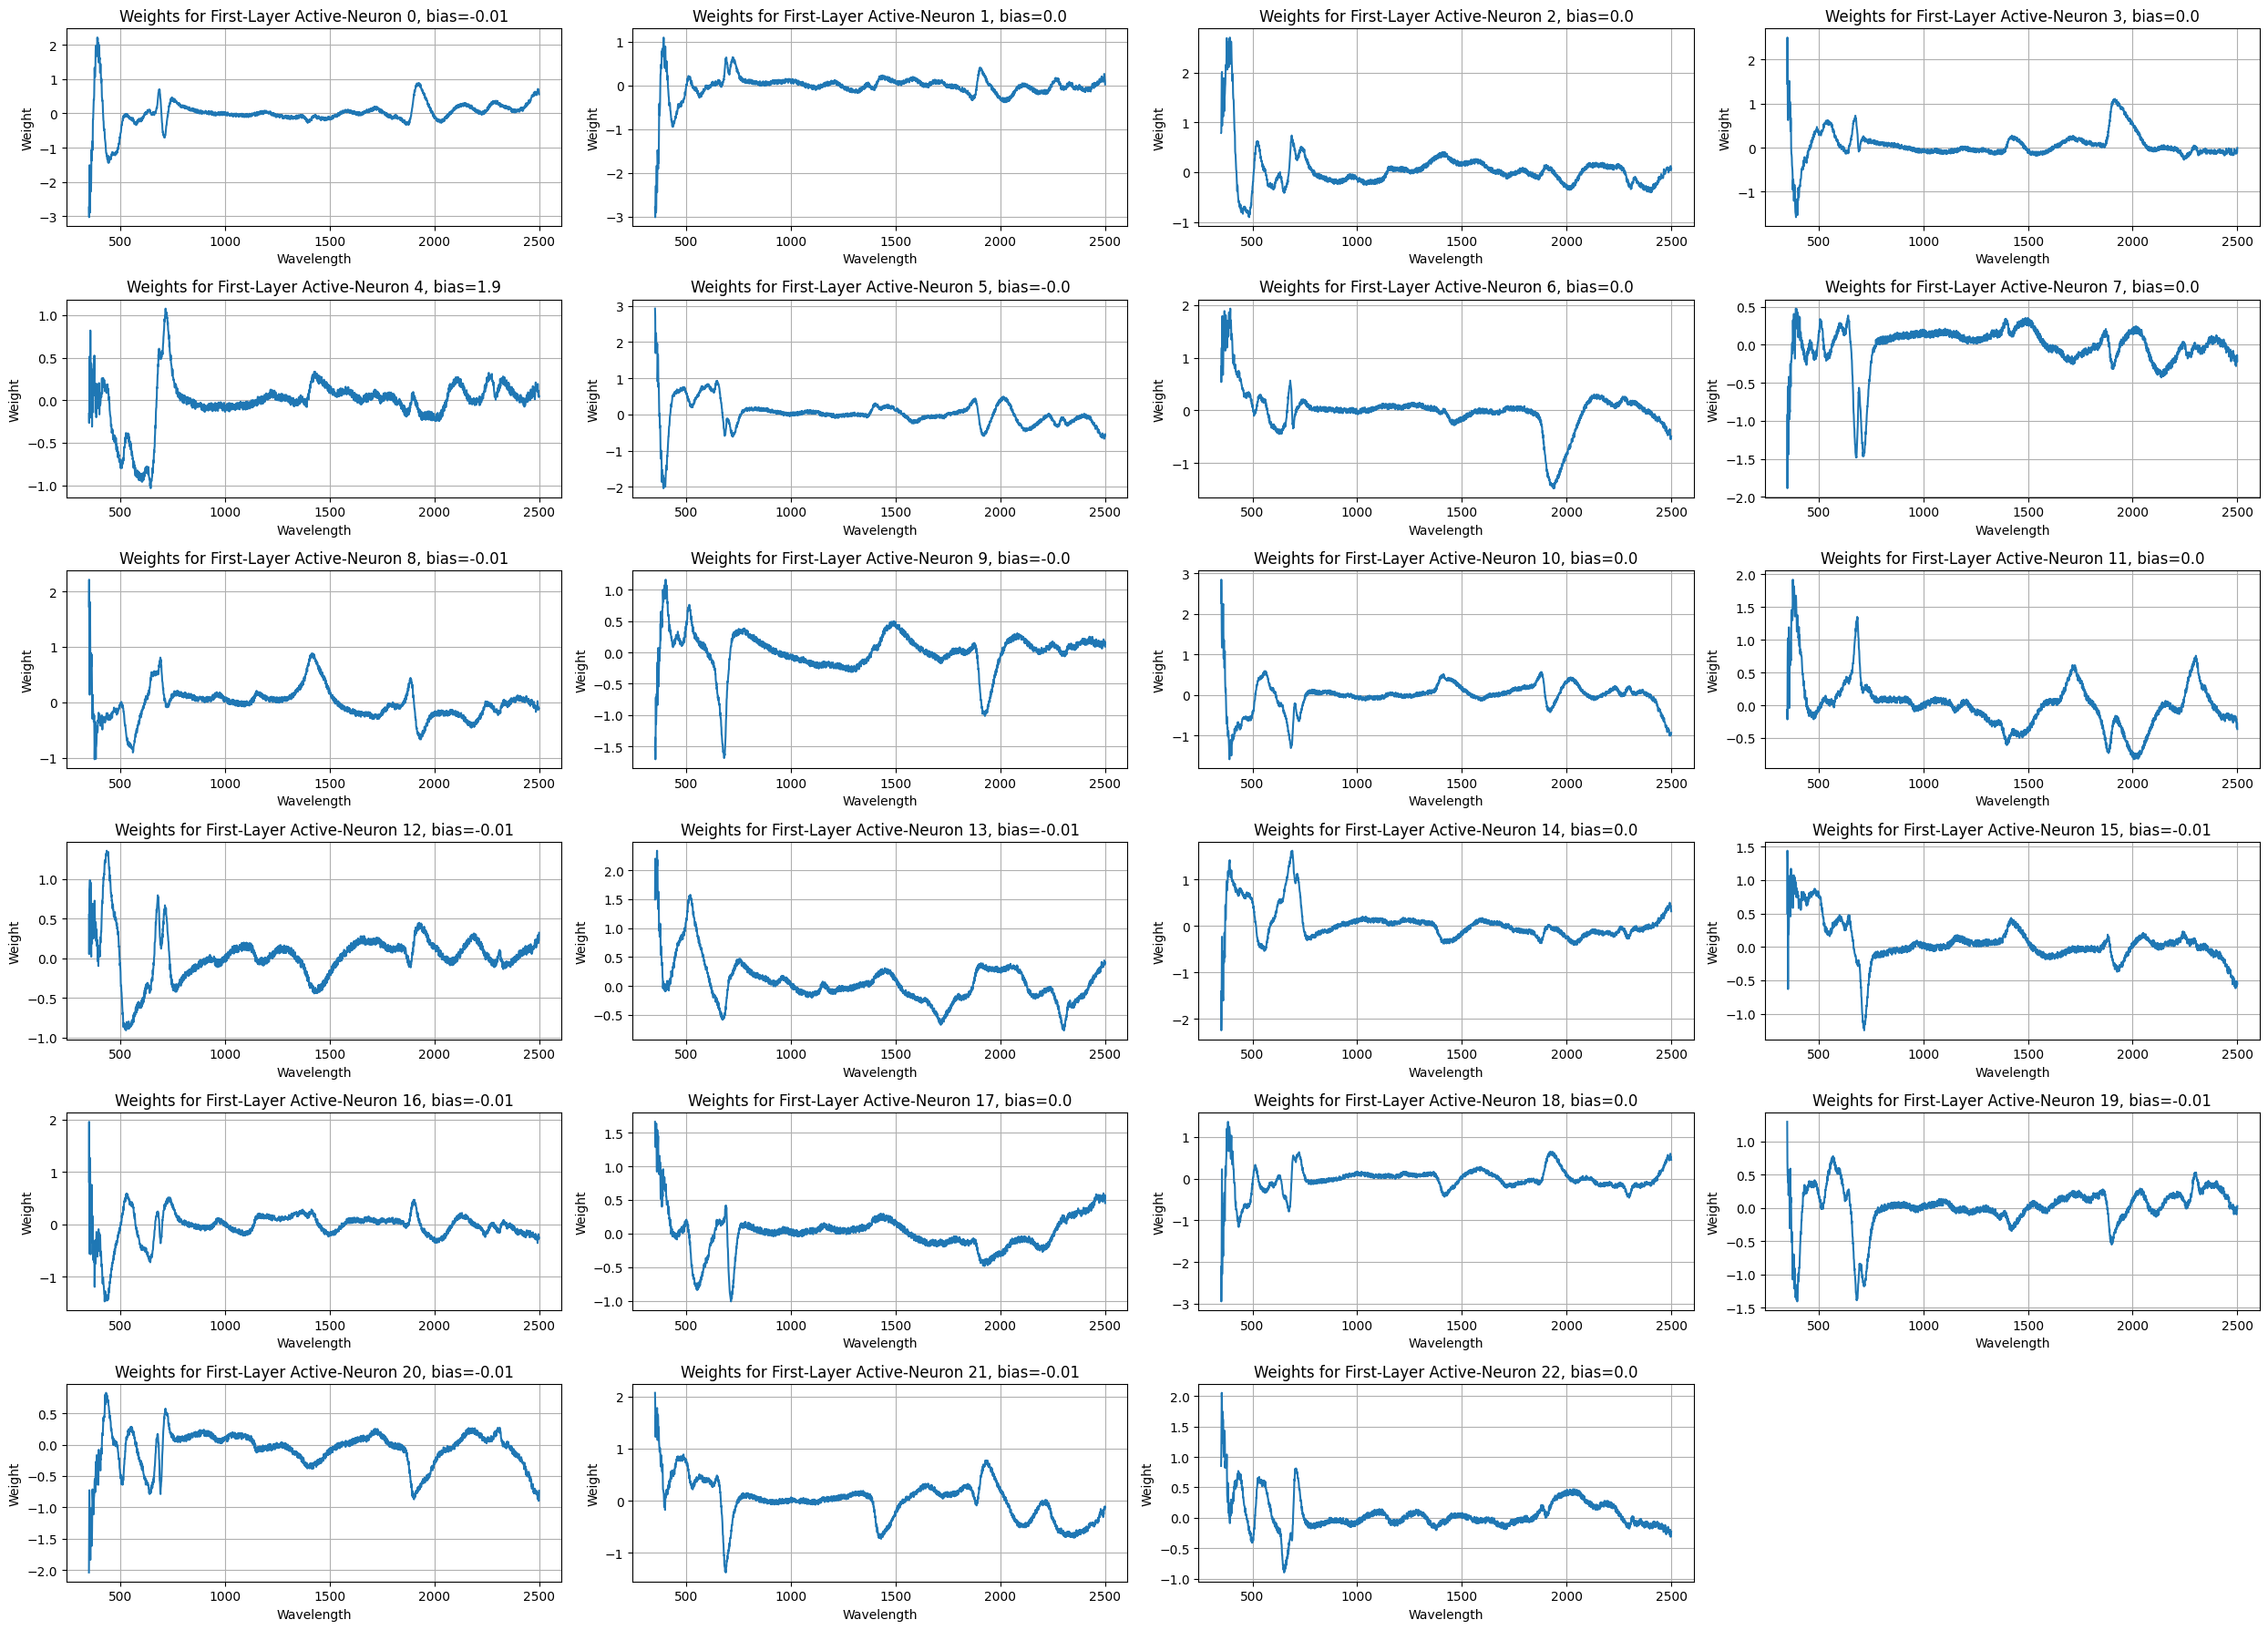

In [223]:
# plot the weights for each active weight in the first layer
rows = int(np.ceil(len(indices)/4))

fig = plt.figure(figsize=(25,18))
for i in range(len(indices)):
    fig.add_subplot(rows,4,i+1)
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer1NeuronWeights.png')

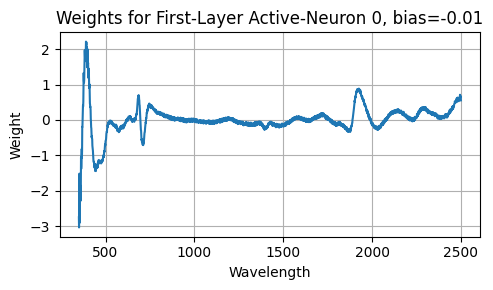

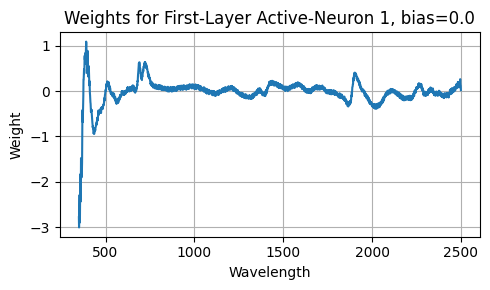

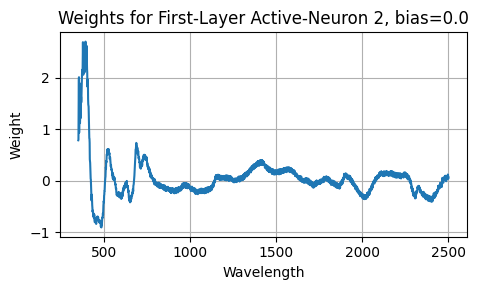

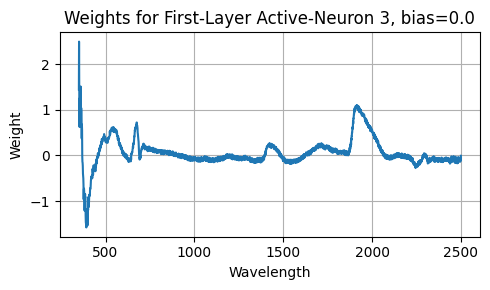

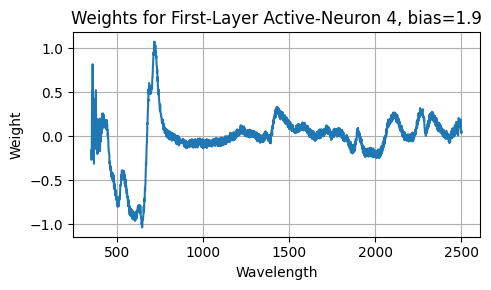

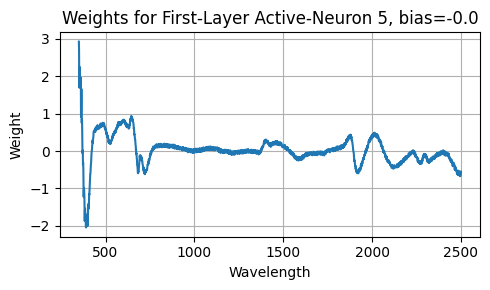

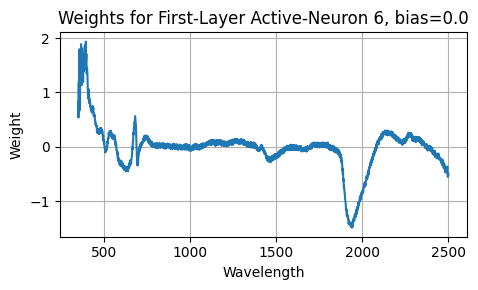

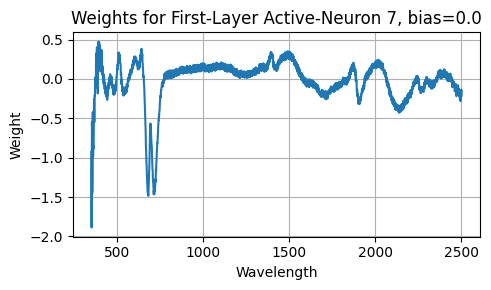

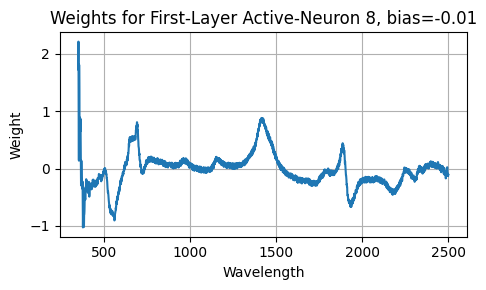

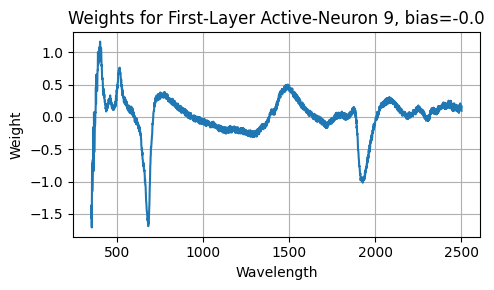

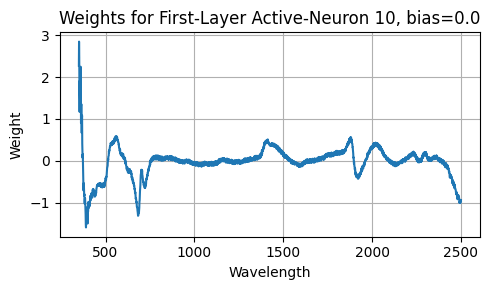

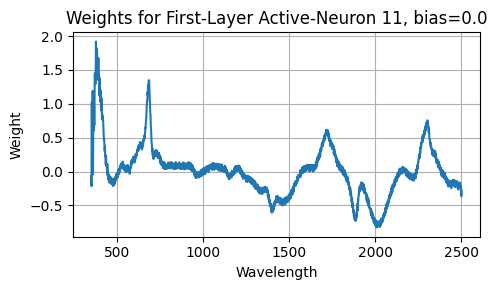

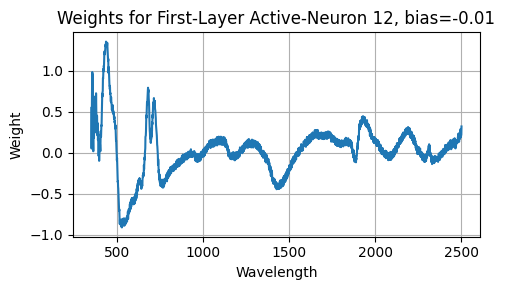

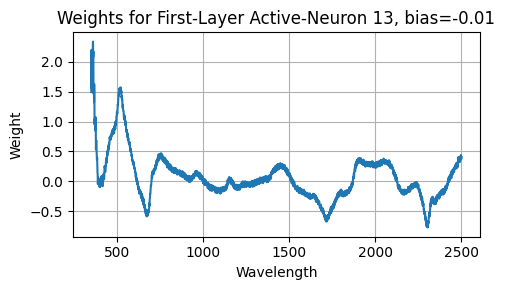

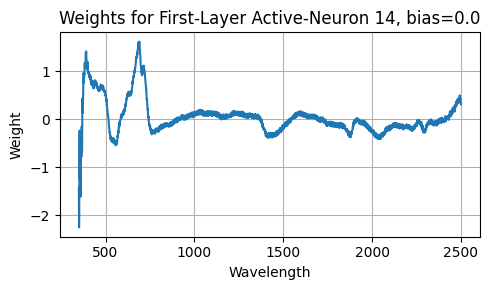

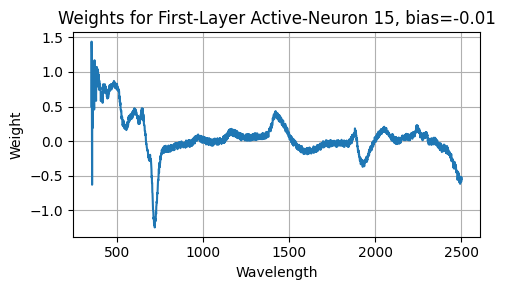

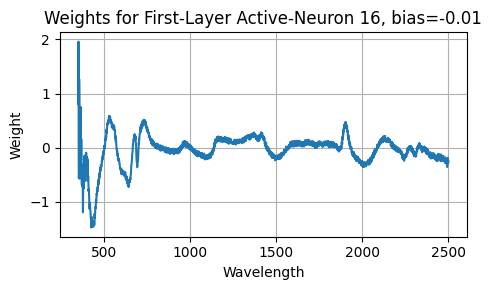

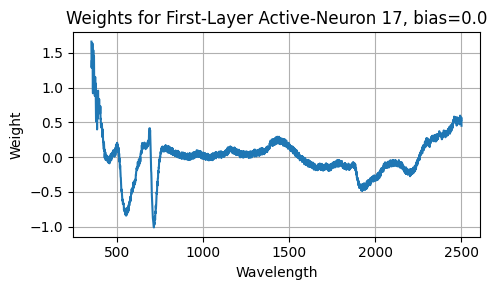

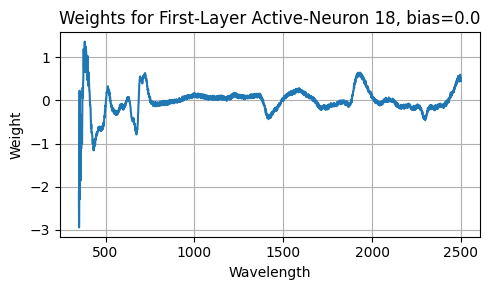

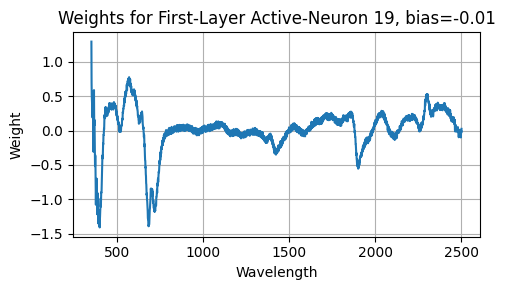

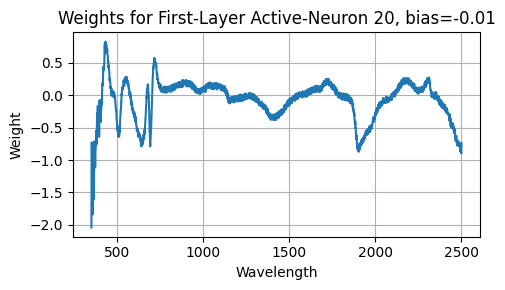

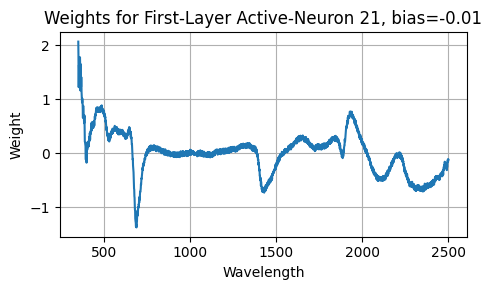

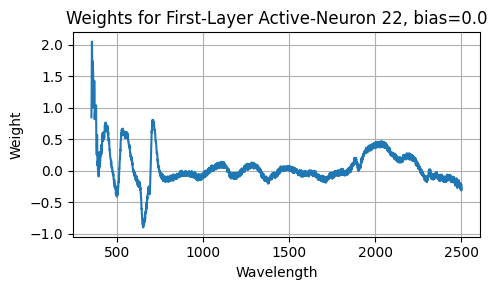

In [249]:
# plot the weights for each active weight in the first layer
for i in range(len(indices)):
    plt.figure(figsize=(5,3))
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
    plt.tight_layout()
    plt.savefig('output/Layer1NeuronWeights_'+str(i)+'.png')

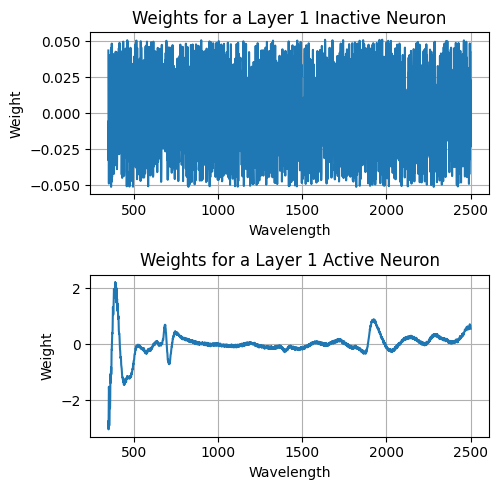

In [283]:
# plot activations for one active neruon and one inactive neuron
i_inact = 1
i_act = 4
fig = plt.figure(figsize=(5,5))

fig.add_subplot(2,1,1)
plt.plot(wl,weights_1[:,i_inact])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Inactive Neuron');

fig.add_subplot(2,1,2)
plt.plot(wl,weights_1[:,i_act])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');

plt.tight_layout()
plt.savefig('output/activeAndInactiveNeurons.png')

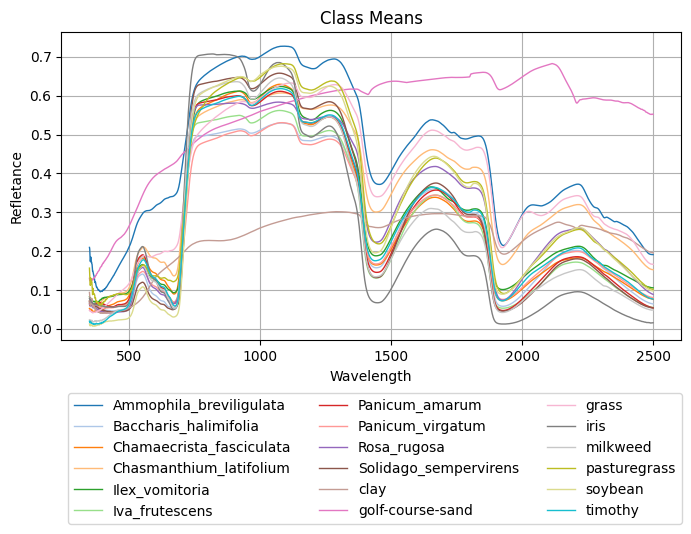

In [ ]:
# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, lw=1, c=clr_n[n])
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left');
plt.savefig('output/meanSpectra.png')

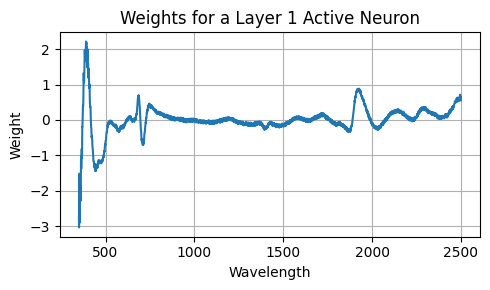

In [256]:
i=4
plt.figure(figsize=(5,3))
plt.plot(wl,weights_1[:,i])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');
plt.tight_layout()
plt.savefig('output/activeNeuron.png')

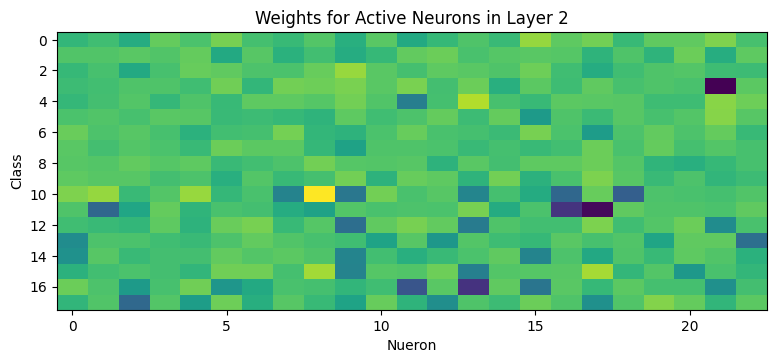

In [267]:
# Visualize the second layer as an image
hidden = model.layers[1]
hidden.name
weights_2, biases_2 = hidden.get_weights()
active_weights_2 = weights_2[indices,:].T

plt.figure(figsize=(8,4))
plt.imshow(active_weights_2, aspect='0.5', interpolation='none');
plt.xlabel('Nueron');
plt.ylabel('Class');
plt.title('Weights for Active Neurons in Layer 2');
plt.tight_layout()
plt.savefig('output/Layer2WeightsIm.png')

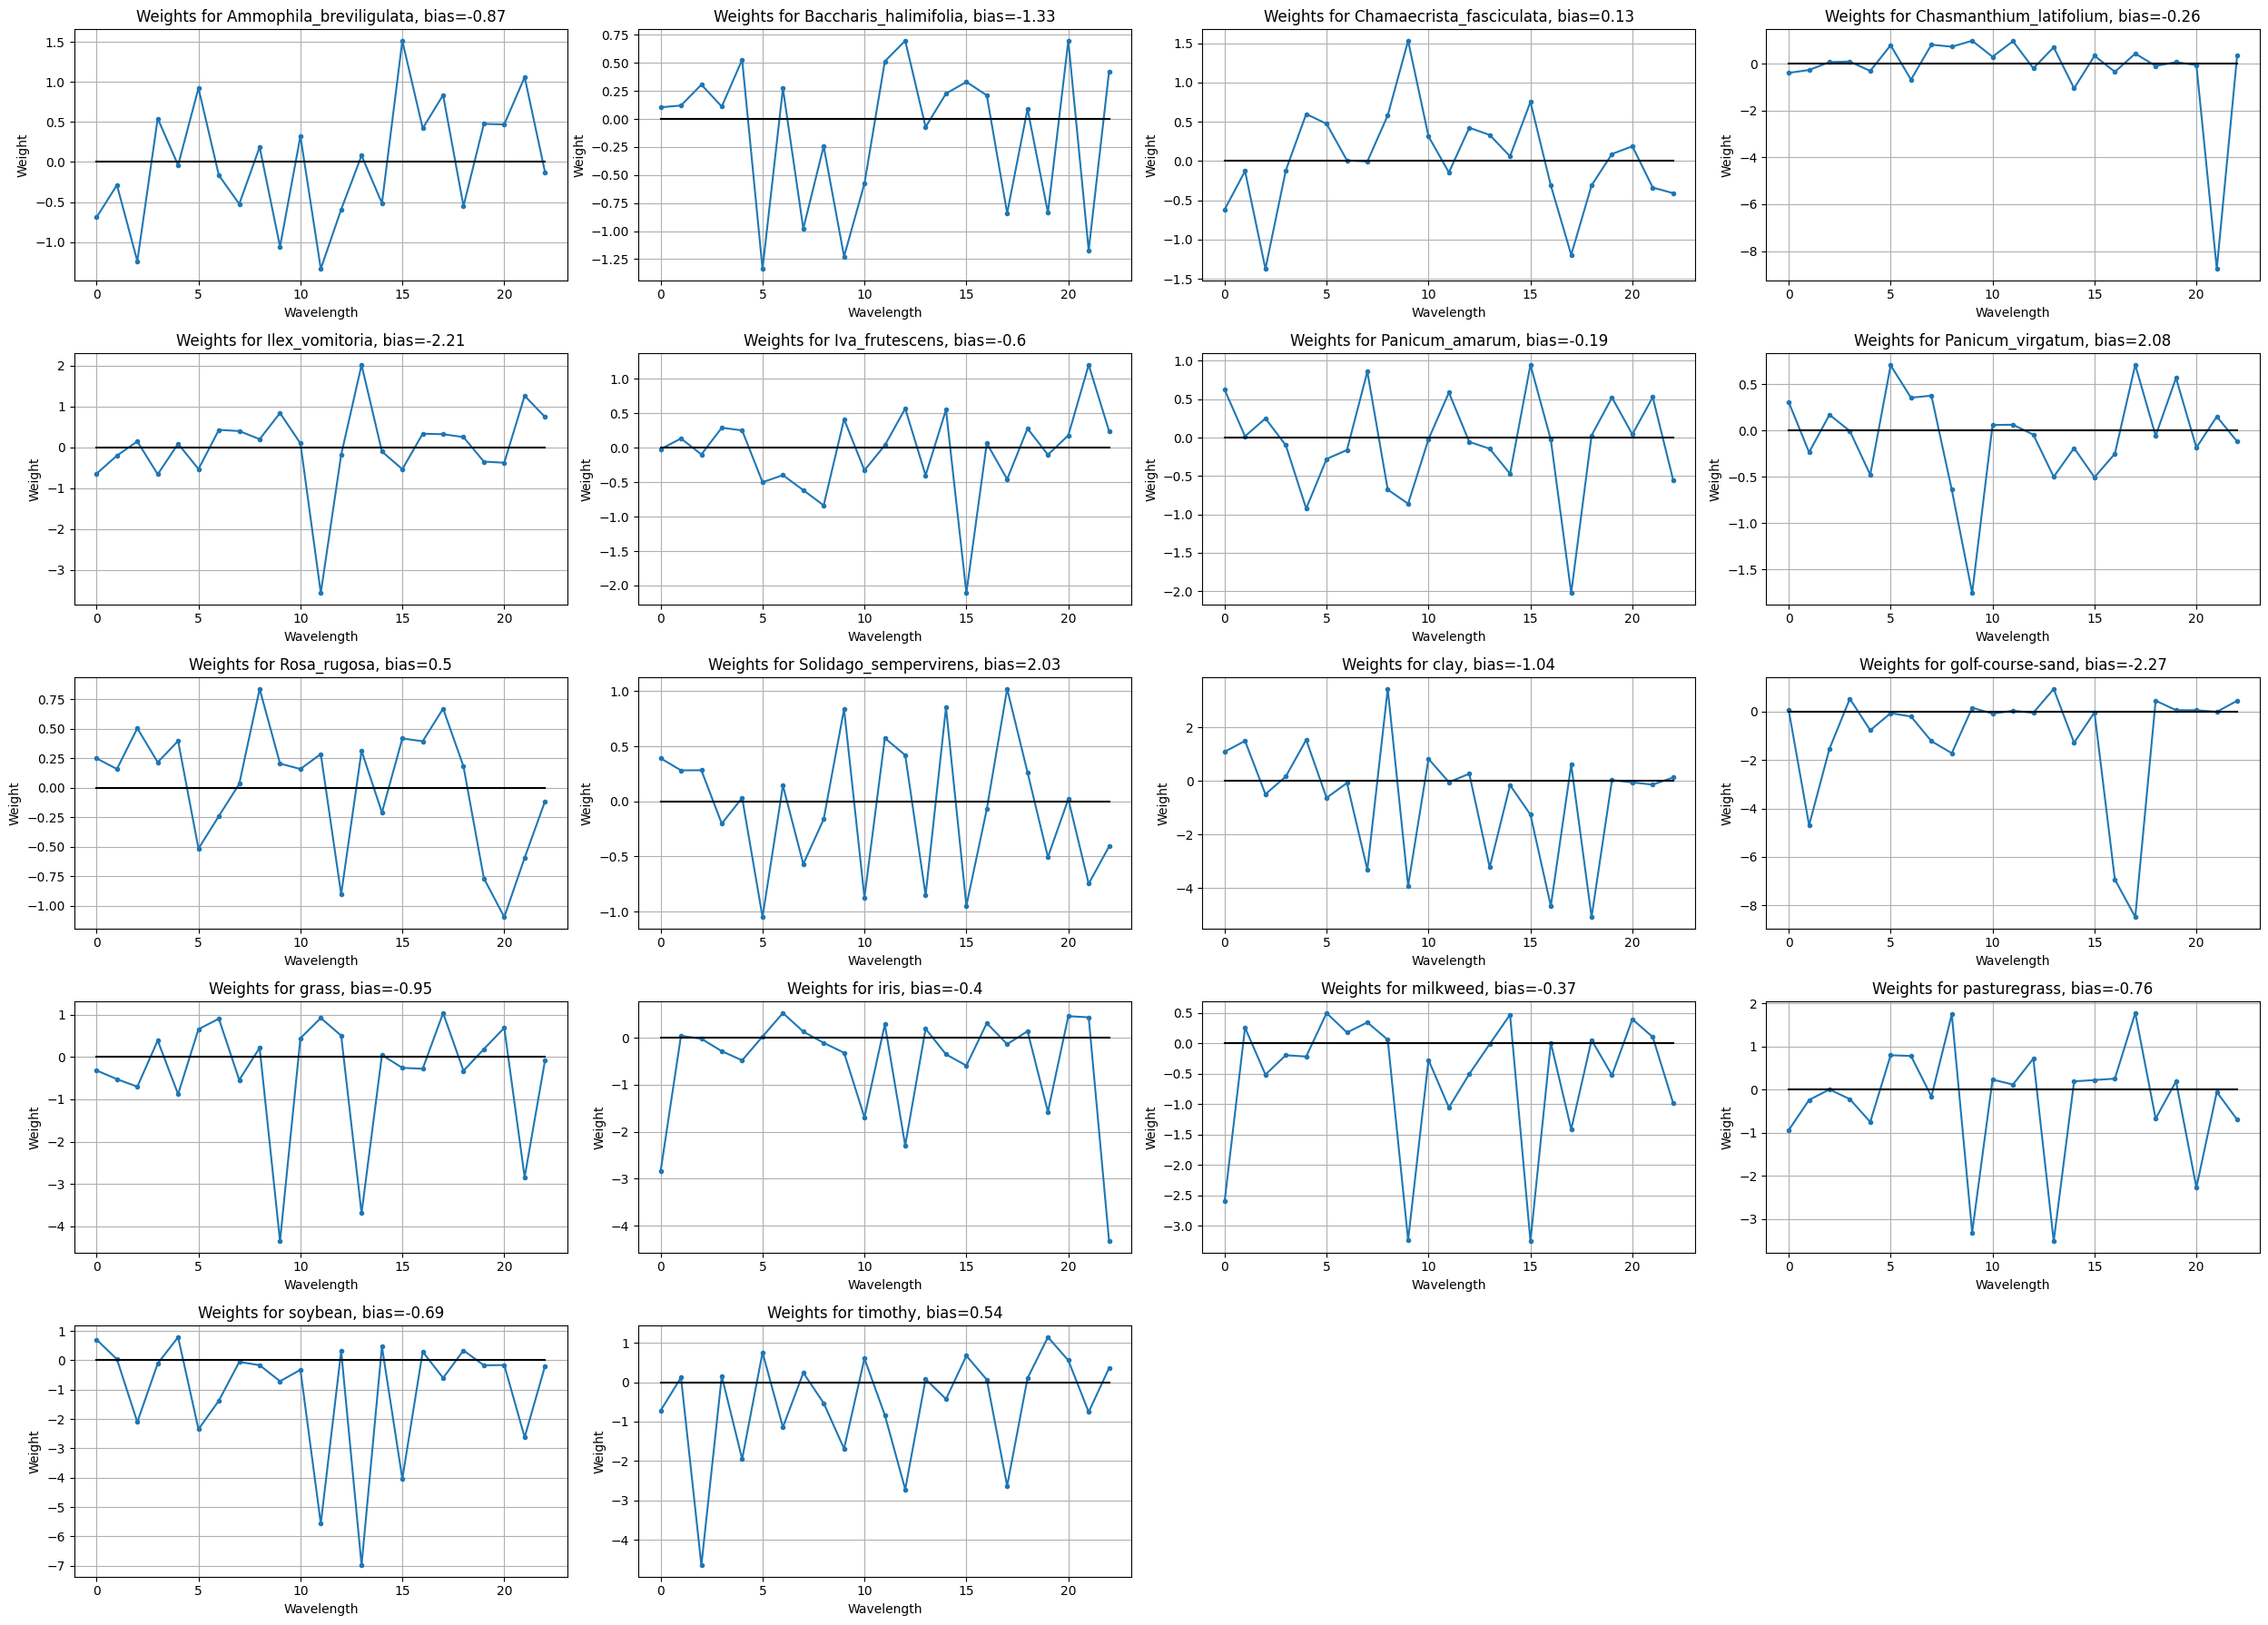

In [50]:
fig = plt.figure(figsize=(25,18))
for i in range(nClasses):
    fig.add_subplot(5,4,i+1)
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for {Y_labels[i]}, bias={str(round(biases_2[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer2ClassWeights.png')

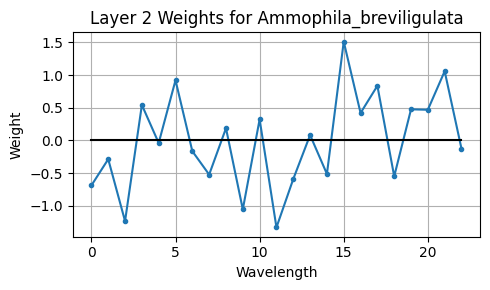

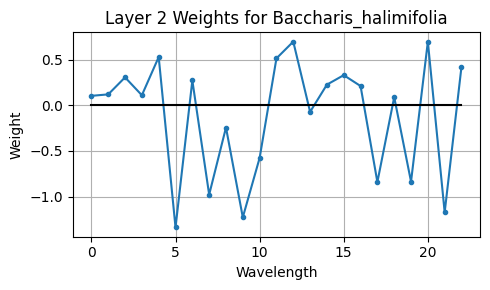

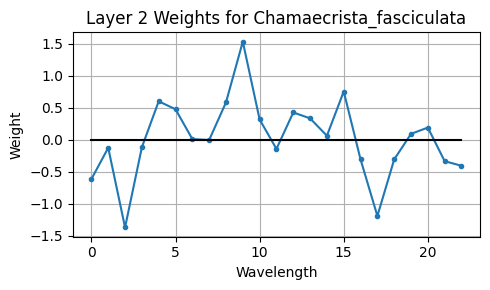

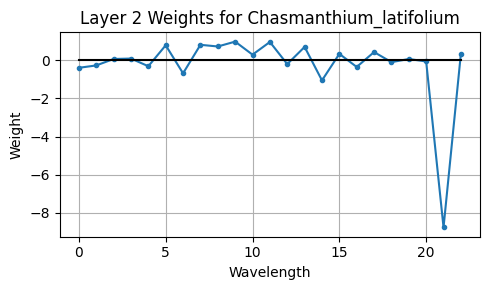

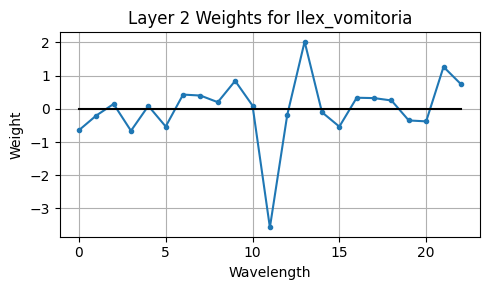

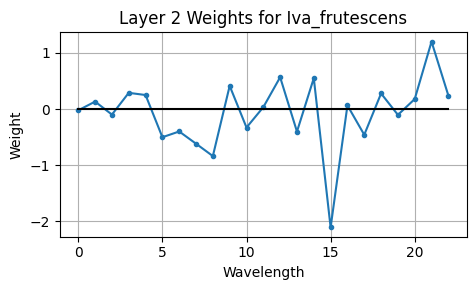

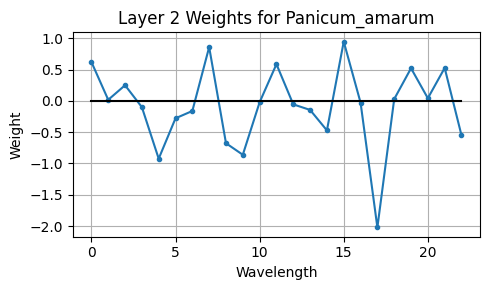

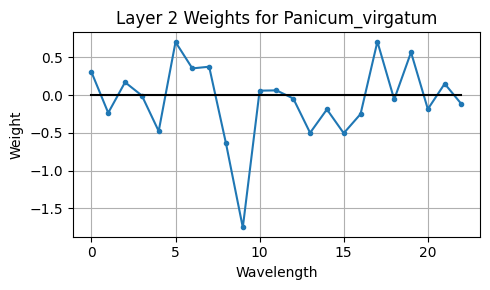

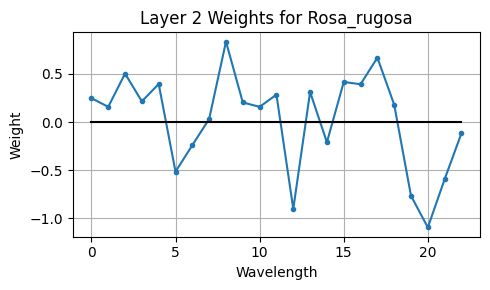

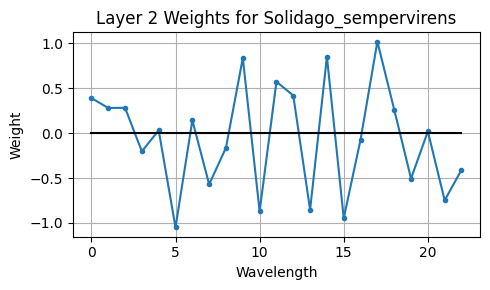

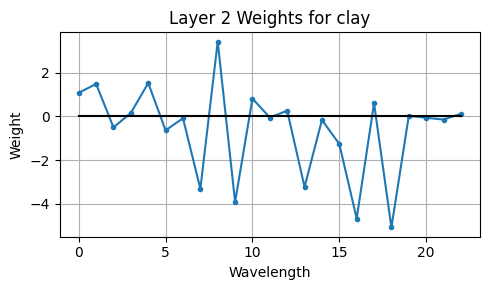

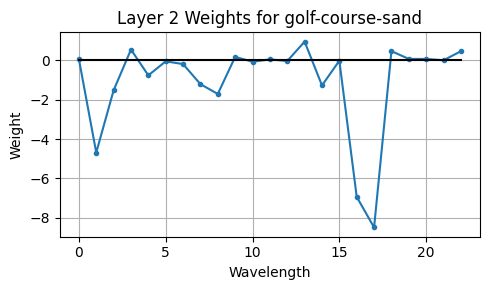

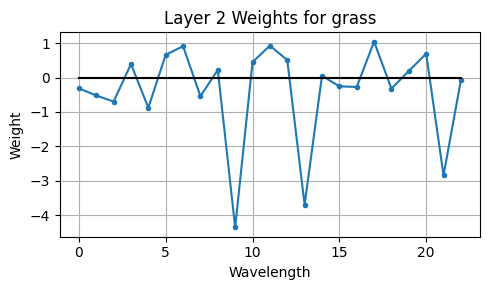

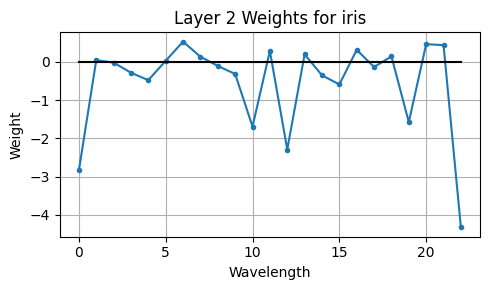

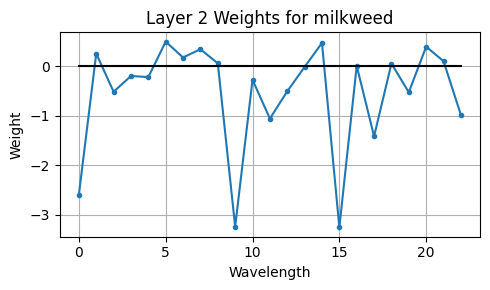

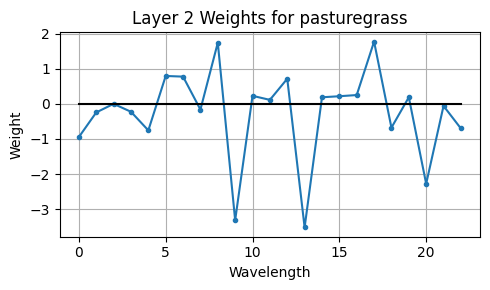

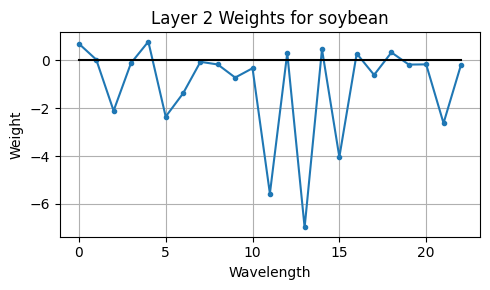

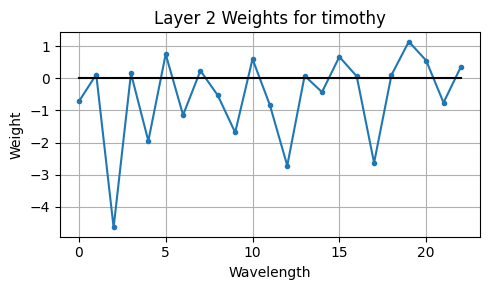

In [272]:
# plot the weights for each active weight in the first layer
for i in range(nClasses):
    plt.figure(figsize=(5,3))
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Layer 2 Weights for {Y_labels[i]}')
    plt.tight_layout()
    plt.savefig('output/Layer2ClassWeights_'+Y_labels[i]+'.png')

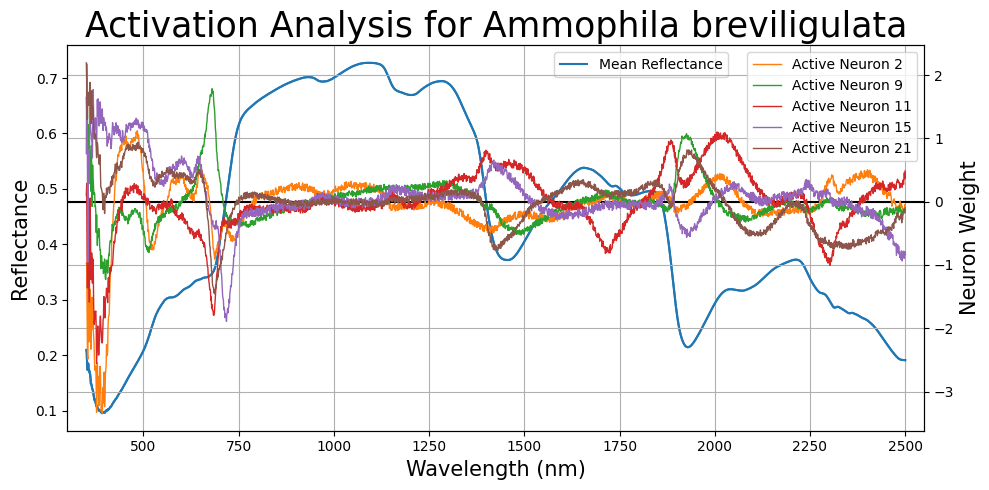

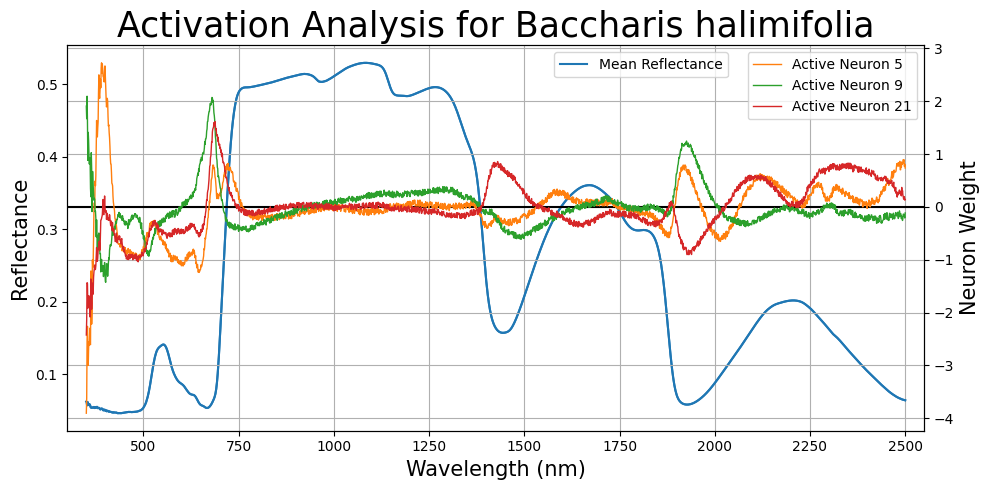

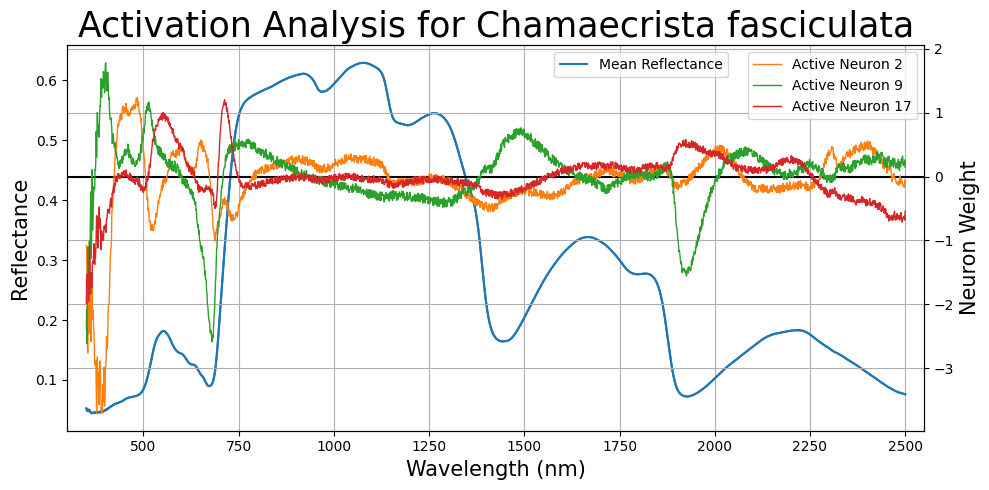

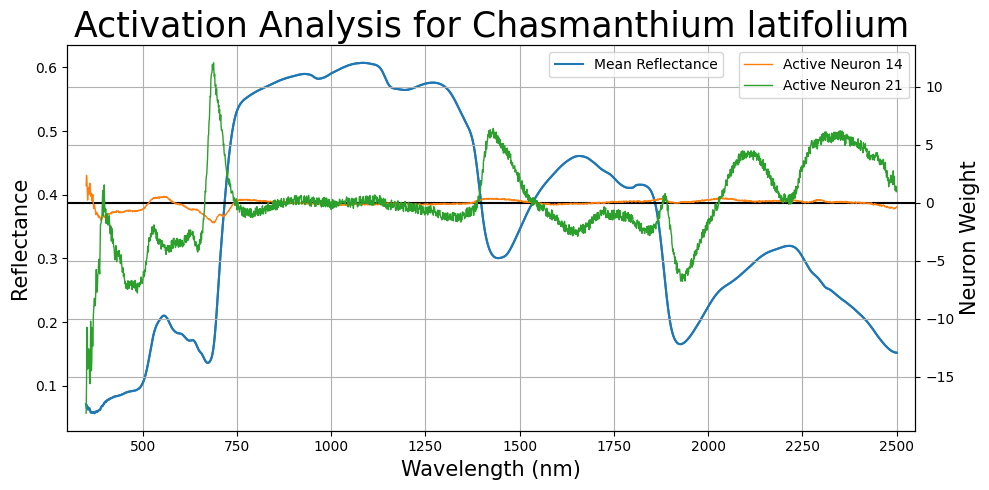

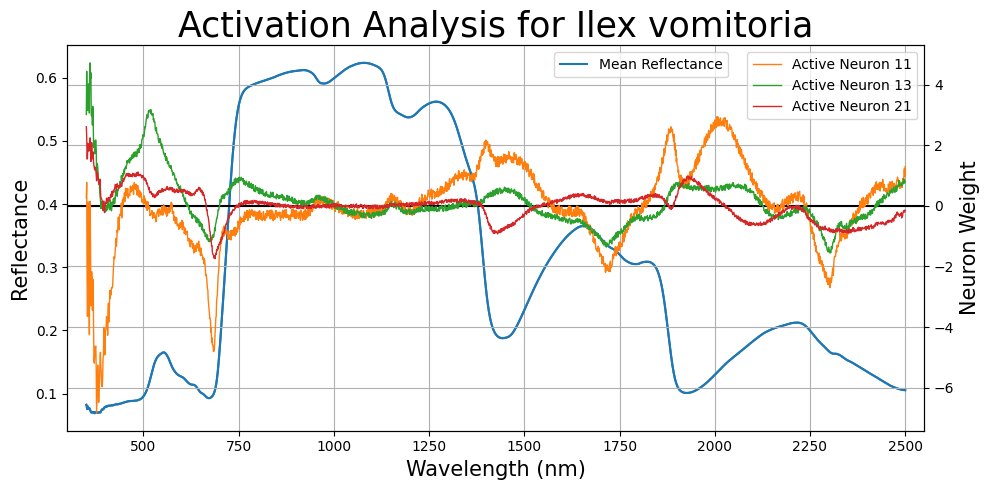

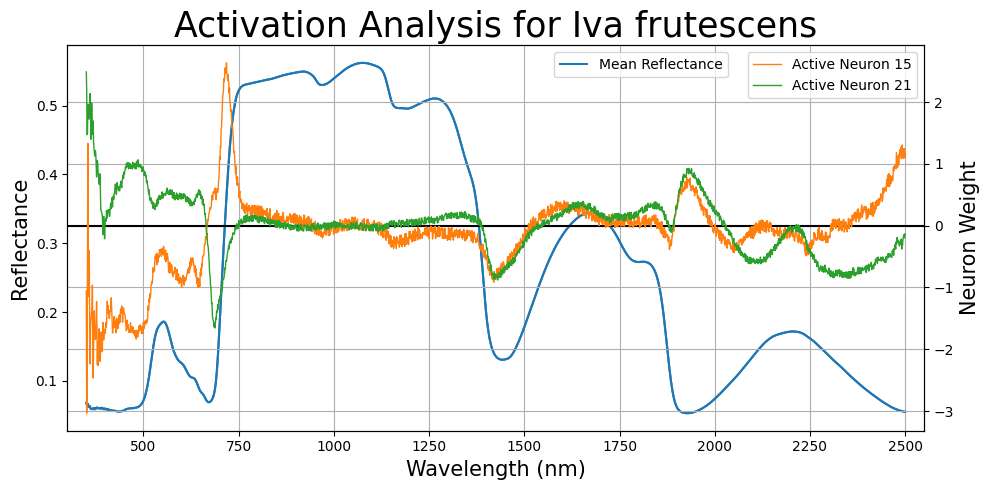

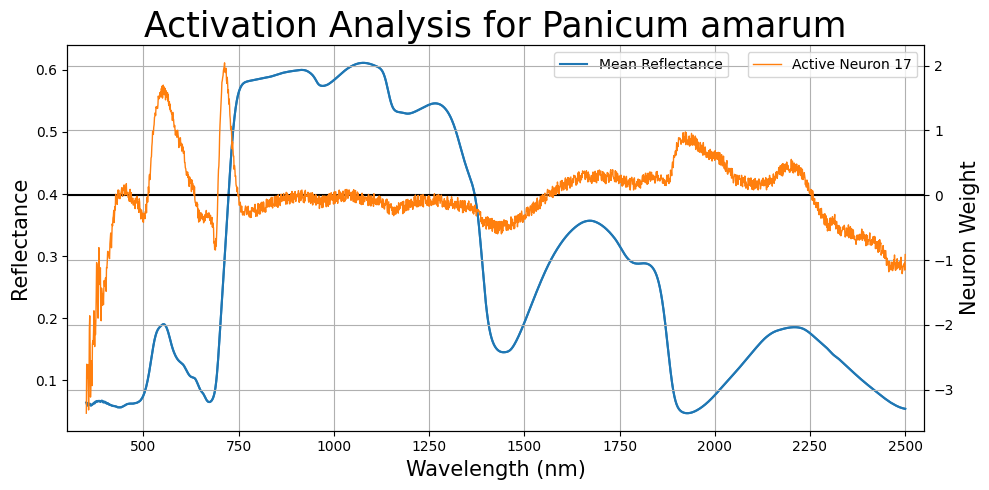

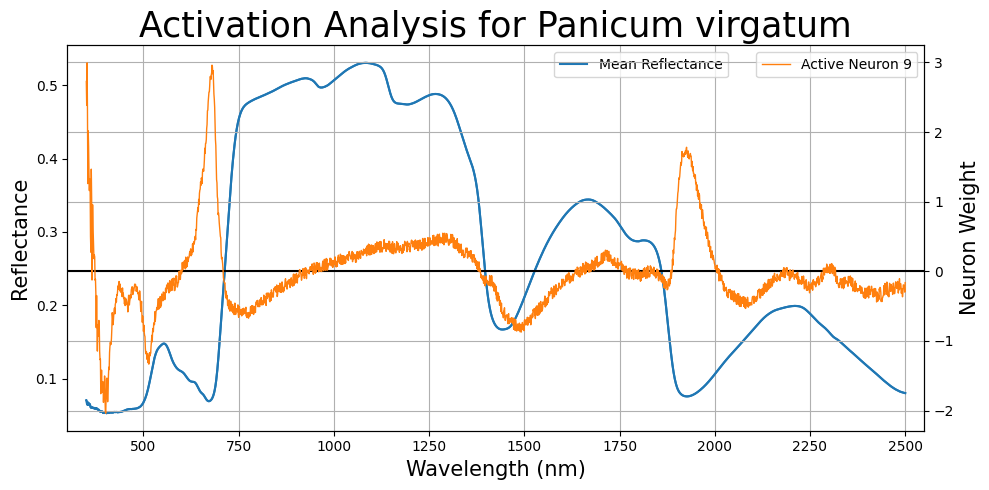

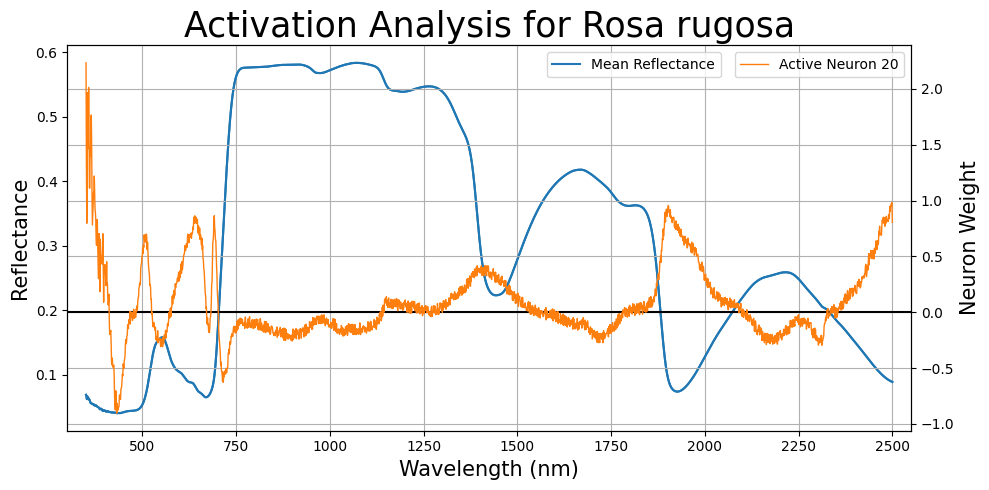

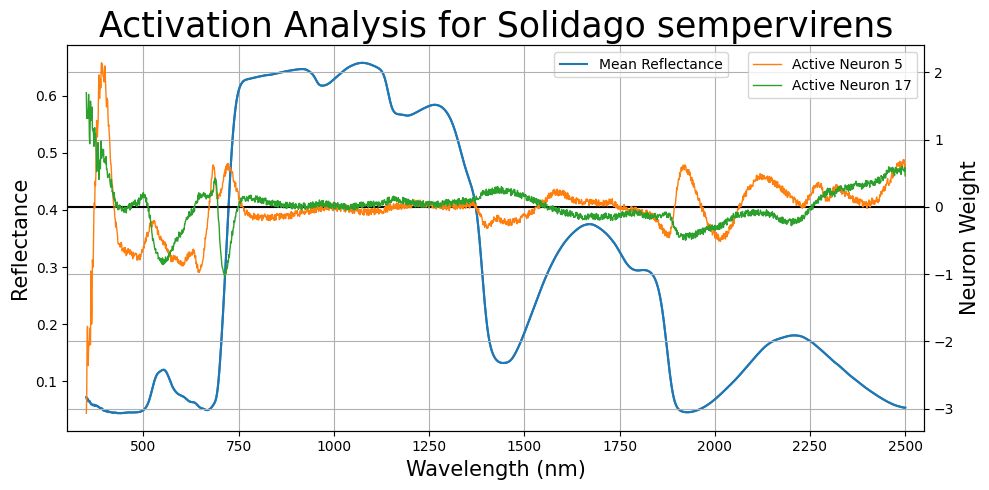

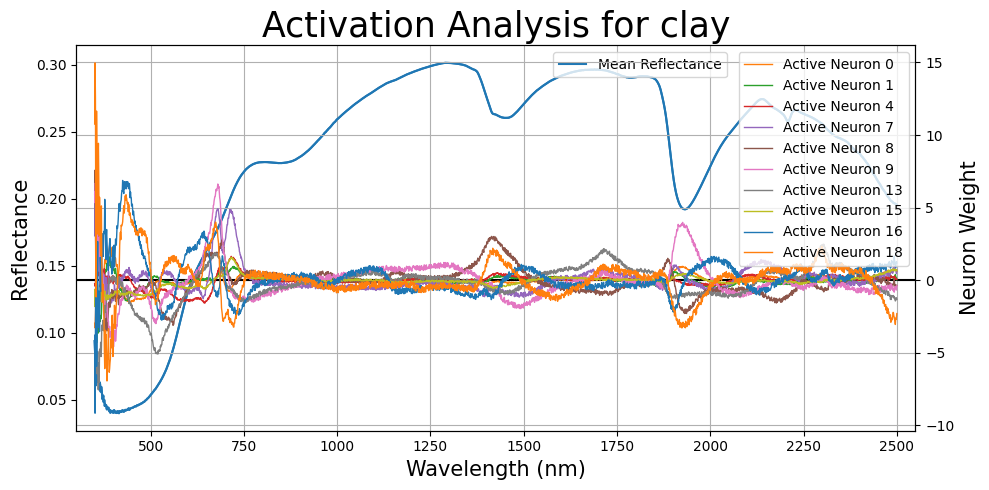

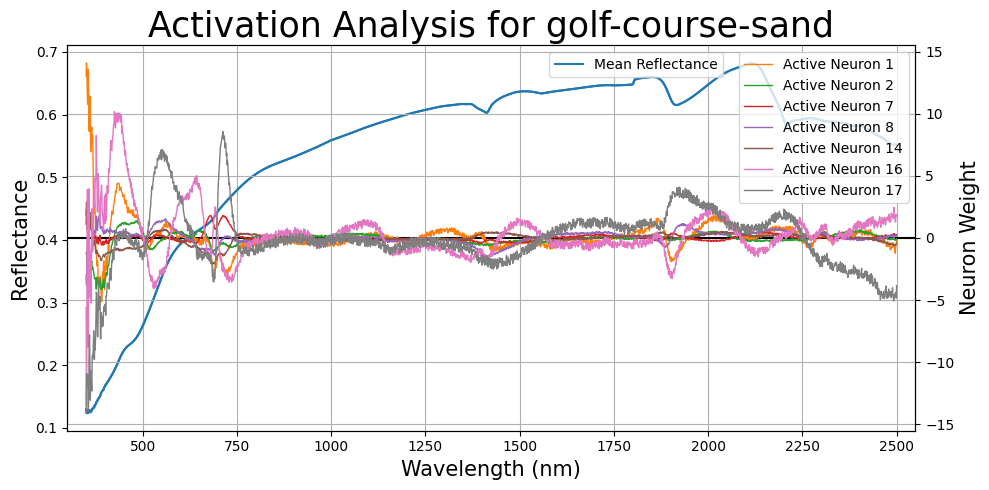

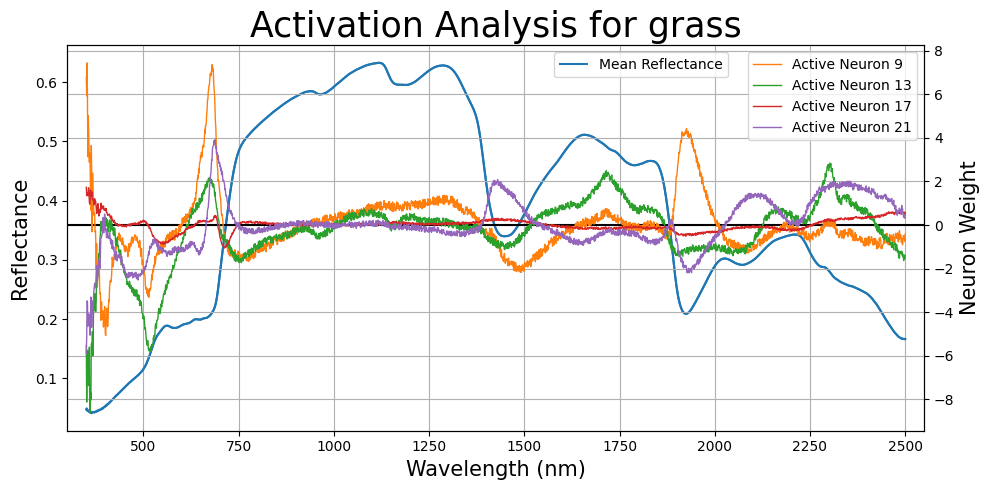

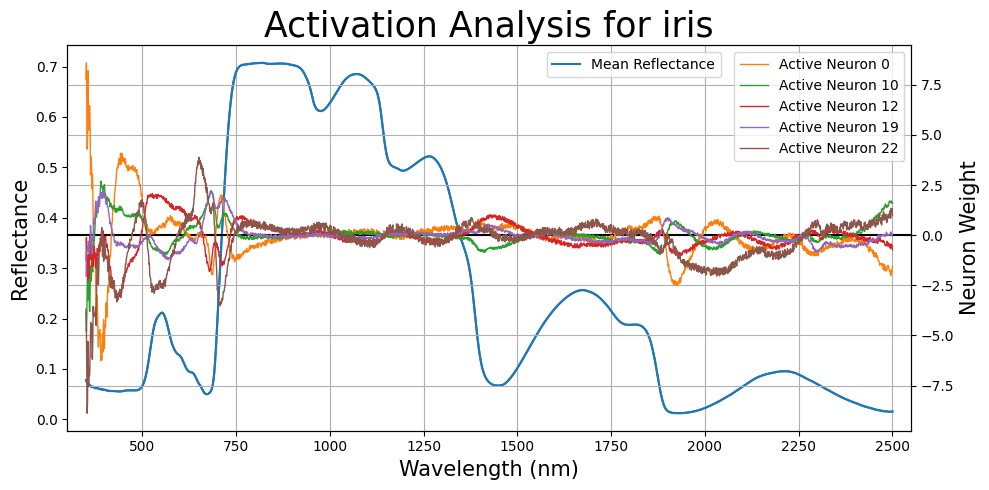

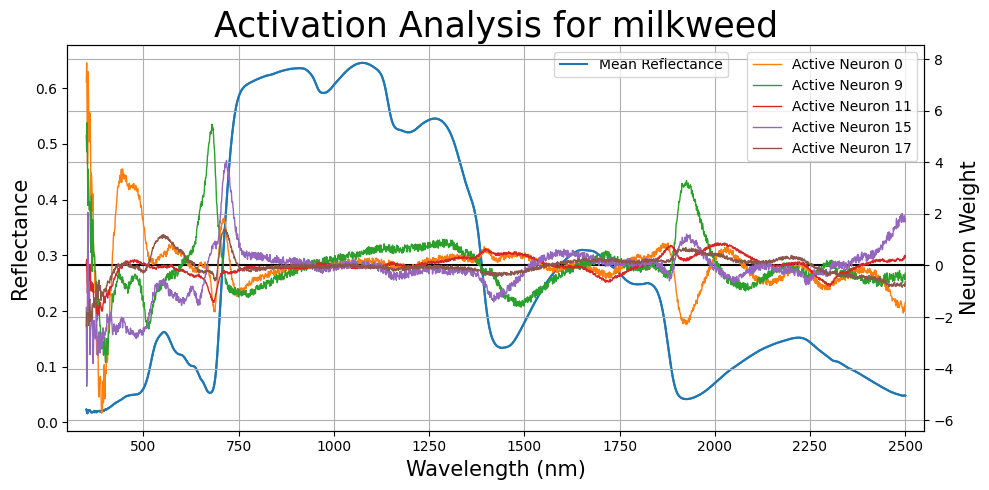

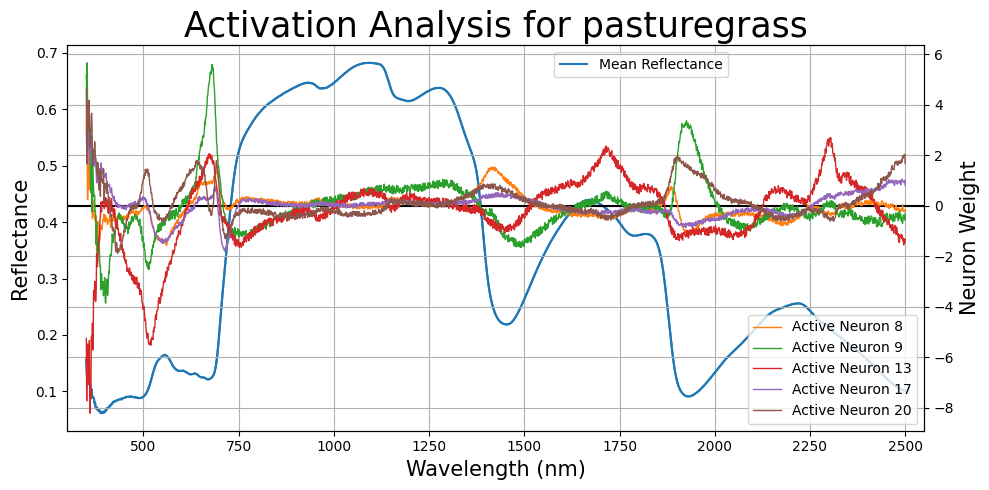

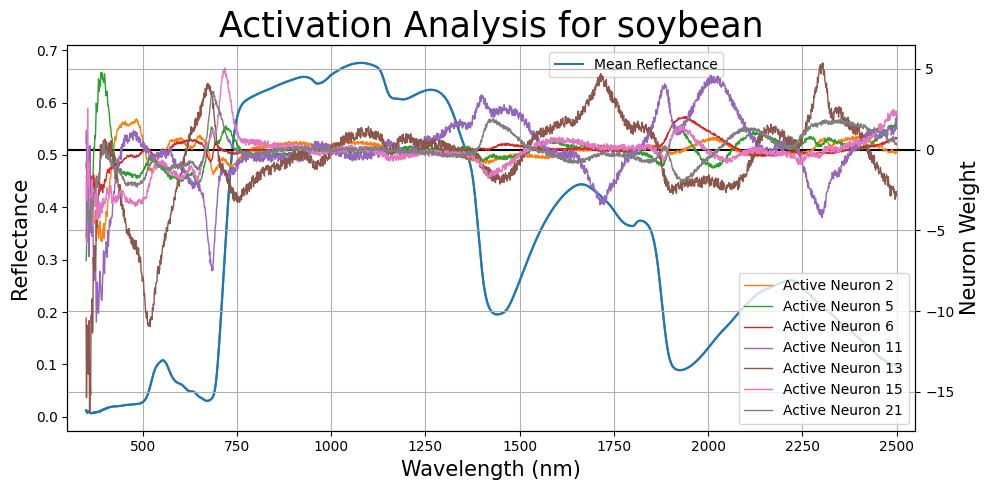

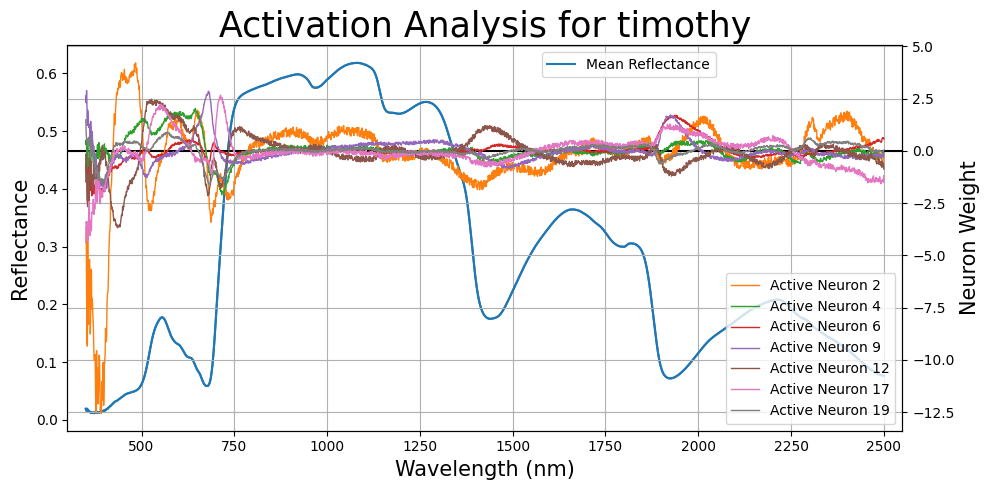

In [287]:
def plot_class_with_activation(class_name):
    
    # Compute the mean spectrum for this class
    class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
    # Compute the index in Y_labels for the name of this class
    name_index = np.where(Y_labels==class_name)[0] 
    # Determine the indices for the neurons in the first layer that are active for this class
    neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>1)[0] 
    # Determine the amount of activation (weights in second layer) for this class
    neuron_activation = active_weights_2[name_index,neuron_indices]

    c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
    ax1.set_ylabel('Reflectance', color='k', fontsize=15)
    ax1.plot(wl,class_mean, color=c[0], label='Mean Reflectance')
    ax1.tick_params(axis='y', labelcolor='k')
    plt.grid(True, axis='x')
    plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

    ax2 = ax1.twinx()  # second axes, for neruon weights
    ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
    ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=1)
    for i,n_i in enumerate(neuron_indices):
        color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
        ax2.plot(wl, neuron_activation[i]*active_weights_1[n_i,:].flatten(), 
                 color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.grid(True)

    ax1.plot(wl,class_mean, color=c[0])
    plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
    plt.xlim(np.min(wl)-50,np.max(wl)+50)
    plt.legend()
    fig.tight_layout()  
    plt.savefig('output/activation_'+class_name+'.png');
    plt.show()

for class_name in Y_labels:
    plot_class_with_activation(class_name)